In [23]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

# Make the VF Solution and use it as input to network

import sys
sys.path.insert(0,'..')
import VF.vectorfit

In [24]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:4


# 1. Load the data and get measurements

In [25]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 14

In [26]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [27]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [28]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 500)
GT S-parameters shape:  (10, 2, 500)
Y S-parameters shape:  (10, 2, 19)


In [29]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (500,)
Y frequencies shape:  (19,)


In [30]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  100000000.0
Mean frequency spacing:  39879759.51903807
STD frequency spacing:  34.77371940703715
Mode frequency spacing:  39879760.0
Number of samples with non-equal spacing:  275


In [31]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [32]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  500
N_SPARAMS:  10


In [33]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 500])


In [34]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 500])


## Plot some stuff

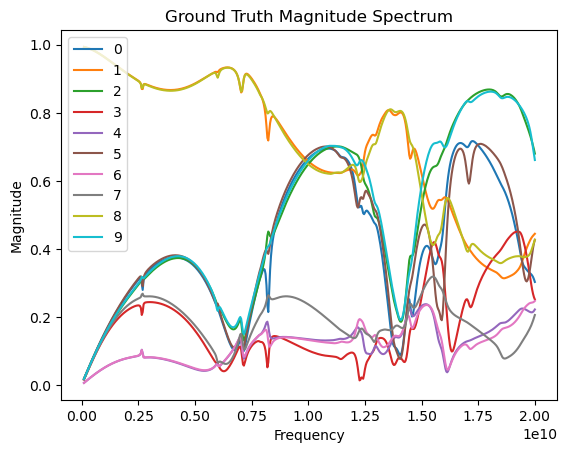

In [35]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

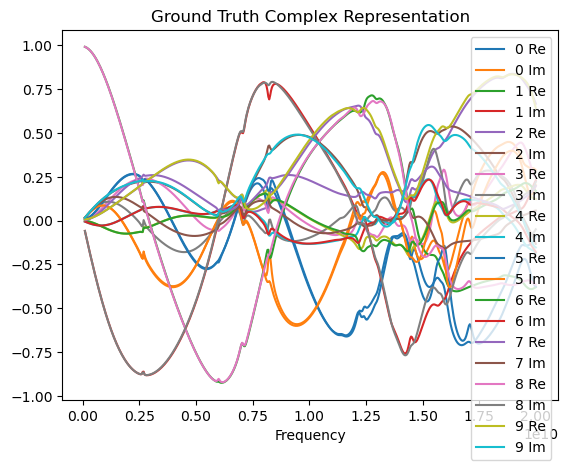

In [36]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [37]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 19

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  500
Number of Measurements:  19
Undersampling Ratio:  0.038
[  0  55 110 166 221 277 332 388 443 499]
[  0  27  55  83 110 138 166 194 221 249 277 304 332 360 388 415 443 471
 499]


In [38]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 10])
y_freqs shape:  (10,)


# 2. Network Setup

## Define network parameters

In [39]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [40]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  5
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [41]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [42]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 500])


In [43]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  283848


# 3. Run

## Define training parameters, losses, and track stats

In [44]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
CURR_ITER = FIRST_ITER
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

print("NUM ACTIVE: ", NUM_ACTIVE)

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        LENGTH_GT = len(gt_freqs)
        cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
        fname = os.path.join(ROOT_PATH, "case"+cn)

        children = os.listdir(fname)
        children = [f for f in children if cn + ".s" in f]

        final_path = os.path.join(fname, children[0])

        fitter = VF.vectorfit.VectorFitter(final_path)
        fit1 = fitter.vector_fit("VF Result", y_freqs) 
        vf_output = fit1.fitted_network.s

        vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
        vf_data = utils.matrix_to_sparams(vf_data)
        vf_data = torch.tensor(vf_data).view(1, -1, LENGTH_GT)
        vf_data = vf_data.to(device)

        
        # Find the maximum standard deviation point, and use it to update kept_inds
        print(sgld_outputs_by_sample)
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1][-1], vf_data, pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]


    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)


    for i in range(int(CURR_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        CURR_ITER = NUM_ITER
        is_initial_fit = False


    def find_max_variance(outputs, vf_outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        print(vf_outputs.shape)
        print(outputs.shape)
        sqr_differences = torch.square(torch.subtract(vf_outputs[0], outputs))

        # Sum to go to [1000]
        sqr_differences = torch.mean(sqr_differences, dim=0)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(sqr_differences) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(sqr_differences, len(sqr_differences))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


NUM ACTIVE:  9
ITER  0
TIME:  4.186548709869385
NOISE LEVEL:  0.9998182334878771

ITER  999
TIME:  33.88576006889343
NOISE LEVEL:  0.8337822234718045

ITER  1999
TIME:  52.68890428543091
NOISE LEVEL:  0.6951927961775853

ITER  2999
TIME:  71.7397575378418
NOISE LEVEL:  0.5796393953385278

ITER  3999
TIME:  89.9306857585907
NOISE LEVEL:  0.4832930238572089

ITER  4999
TIME:  108.31062912940979
NOISE LEVEL:  0.40296113202007533

ITER  5999
TIME:  126.76252913475037
NOISE LEVEL:  0.33598182862841364

ITER  6999
TIME:  146.37122201919556
NOISE LEVEL:  0.28013567611992135

ITER  7999
TIME:  165.69847702980042
NOISE LEVEL:  0.2335721469090449

ITER  8999
TIME:  185.69762635231018
NOISE LEVEL:  0.1947483039909062

ITER  9999
TIME:  205.02618622779846
NOISE LEVEL:  0.16237767391890093

ITER  10999
TIME:  225.16116452217102
NOISE LEVEL:  0.1353876180022807

ITER  11999
TIME:  244.5280635356903
NOISE LEVEL:  0.11288378916849302

ITER  12999
TIME:  263.8919429779053
NOISE LEVEL:  0.09412049672682

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


ITER  999
TIME:  420.14150285720825
NOISE LEVEL:  0.0219839264886308

ITER  1999
TIME:  448.1737861633301
NOISE LEVEL:  0.018329807108331275

NUM_SAMPLES  1
TIME:  448.1737861633301
Performing fit with 1 poles.
  Fitting took 0.013079656288027763 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.015734216198325157 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 3 poles better than 2 (err 0.07403415166068542 vs 0.19683574174905744)
Performing fit with 3 poles.
  Fitting took 0.11830048635601997 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 3 (err 0.08266072762146082 vs 0.07403415166068542)
Fit completed in 0.22697687149047852, using 3, resulting in a fit with 3 and error=0.07403415166068542 vs samples and error=0.1525532932383542 vs ground truth.
[tensor([[[-6.0843e-03, -7.291

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.18639879301190376 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 3 (err 0.06061598858643 vs 0.07343282123691318)
Fit completed in 0.3636500835418701, using 4, resulting in a fit with 5 and error=0.06061598858643 vs samples and error=1.1239351959741775 vs ground truth.
[tensor([[[-6.0843e-03, -7.2919e-03, -9.2152e-03,  ..., -3.1663e-01,
          -3.2466e-01, -3.3267e-01],
         [-4.8101e-04, -1.4944e-03,  3.4123e-04,  ...,  1.7062e-01,
           1.7938e-01,  2.0002e-01],
         [ 8.4027e-01,  8.4135e-01,  8.4152e-01,  ..., -3.9596e-01,
          -3.9283e-01, -3.6609e-01],
         ...,
         [-8.2363e-03, -2.5034e-02, -5.1968e-02,  ..., -8.3335e-02,
           4.4260e-03,  8.7726e-02],
         [ 6.3684e-02,  6.6962e-02,  7.2477e-02,  ...,  5.1824e-01,
           5.3803e-01,  5.4457e-01],
         [ 5.6084e-04,  1.7084e-03, -5.0721e-03,  ...,  2.3172e-02,
          -1.5806e-03, -4.6904e-02]],

In [45]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([455, 20, 500])
torch.Size([20, 500])
torch.Size([20, 500])


## Plot metrics and outputs

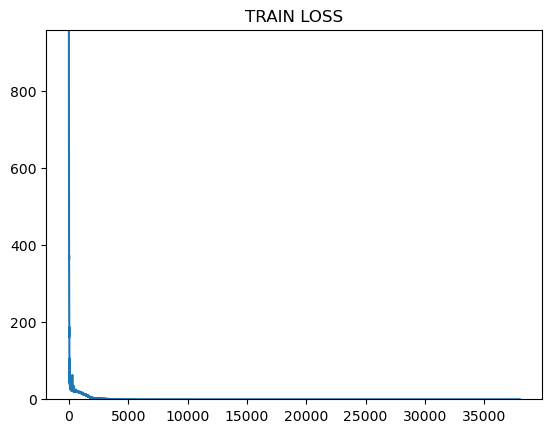

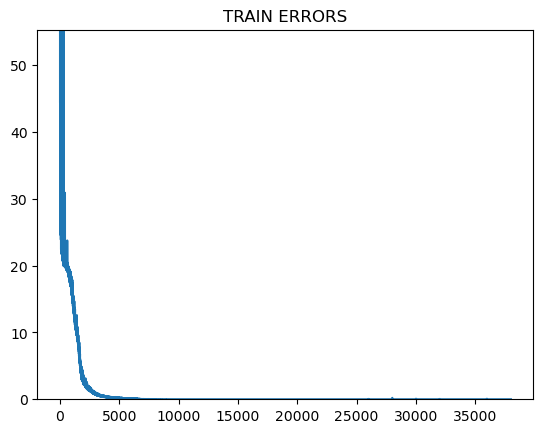

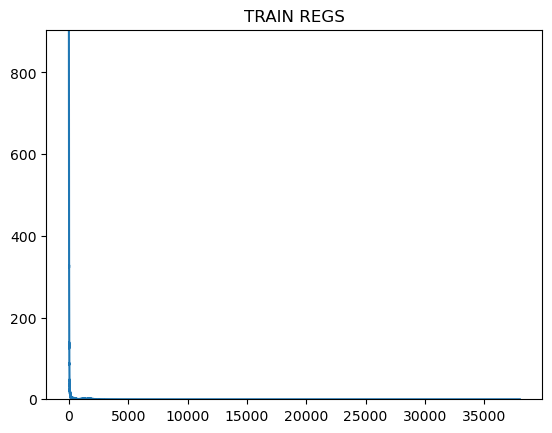

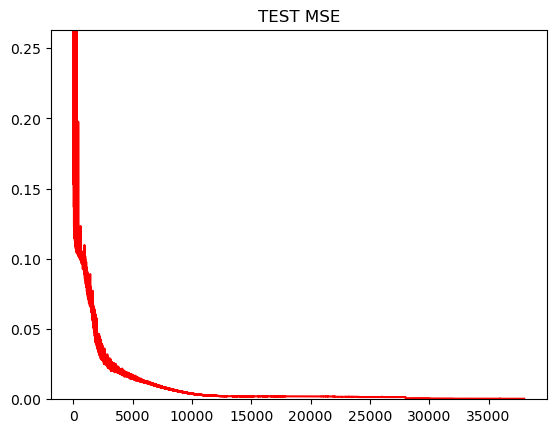

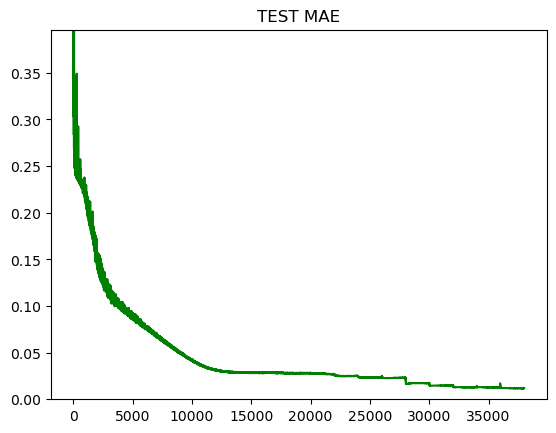

In [46]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [47]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.0003819042176473886
Best Test MSE:  0.0003724377602338791
Best Test MSE Iteration:  37781


In [48]:
LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case14/case14.s4p
[1.00000000e+08 8.57715431e+08 2.29338677e+09 3.21062124e+09
 4.48677355e+09 6.72004008e+09 8.91342685e+09 1.11466934e+10
 1.33400802e+10 1.46561122e+10 1.55733467e+10 1.59322645e+10
 1.64905812e+10 1.77667335e+10 1.80857715e+10 1.89232465e+10
 1.94018036e+10 1.99601202e+10 2.00000000e+10]
Performing fit with 1 poles.
  Fitting took 0.012236393988132477 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.02301965467631817 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 3 poles better than 2 (err 0.08672666569474018 vs 0.24405646189700803)
Performing fit with 3 poles.
  Fitting took 0.05664948374032974 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 3 (err 0.09079569775036091 vs 0.08672666569474018)
Performing fit wit

In [49]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([500, 4, 4, 2])
torch.Size([500, 4, 4, 2])
torch.Size([19, 4, 4, 2])
(500, 4, 4, 2)
(500, 4, 4, 2)
(10, 2, 500)
(10, 2, 500)
float32
float32
DIP PSNR:       40.20105537813735
VF PSNR:        41.146680348964644
Final DIP MSE:  0.0003819042176473886
VF MSE:         0.00030717928893864155
Mean DIP MSE:  0.00037694568163715303


(500,)
torch.Size([20, 500])
torch.Size([1, 20, 500])
torch.Size([1, 20, 19])
torch.Size([1, 20, 500])
torch.Size([1, 20, 500])


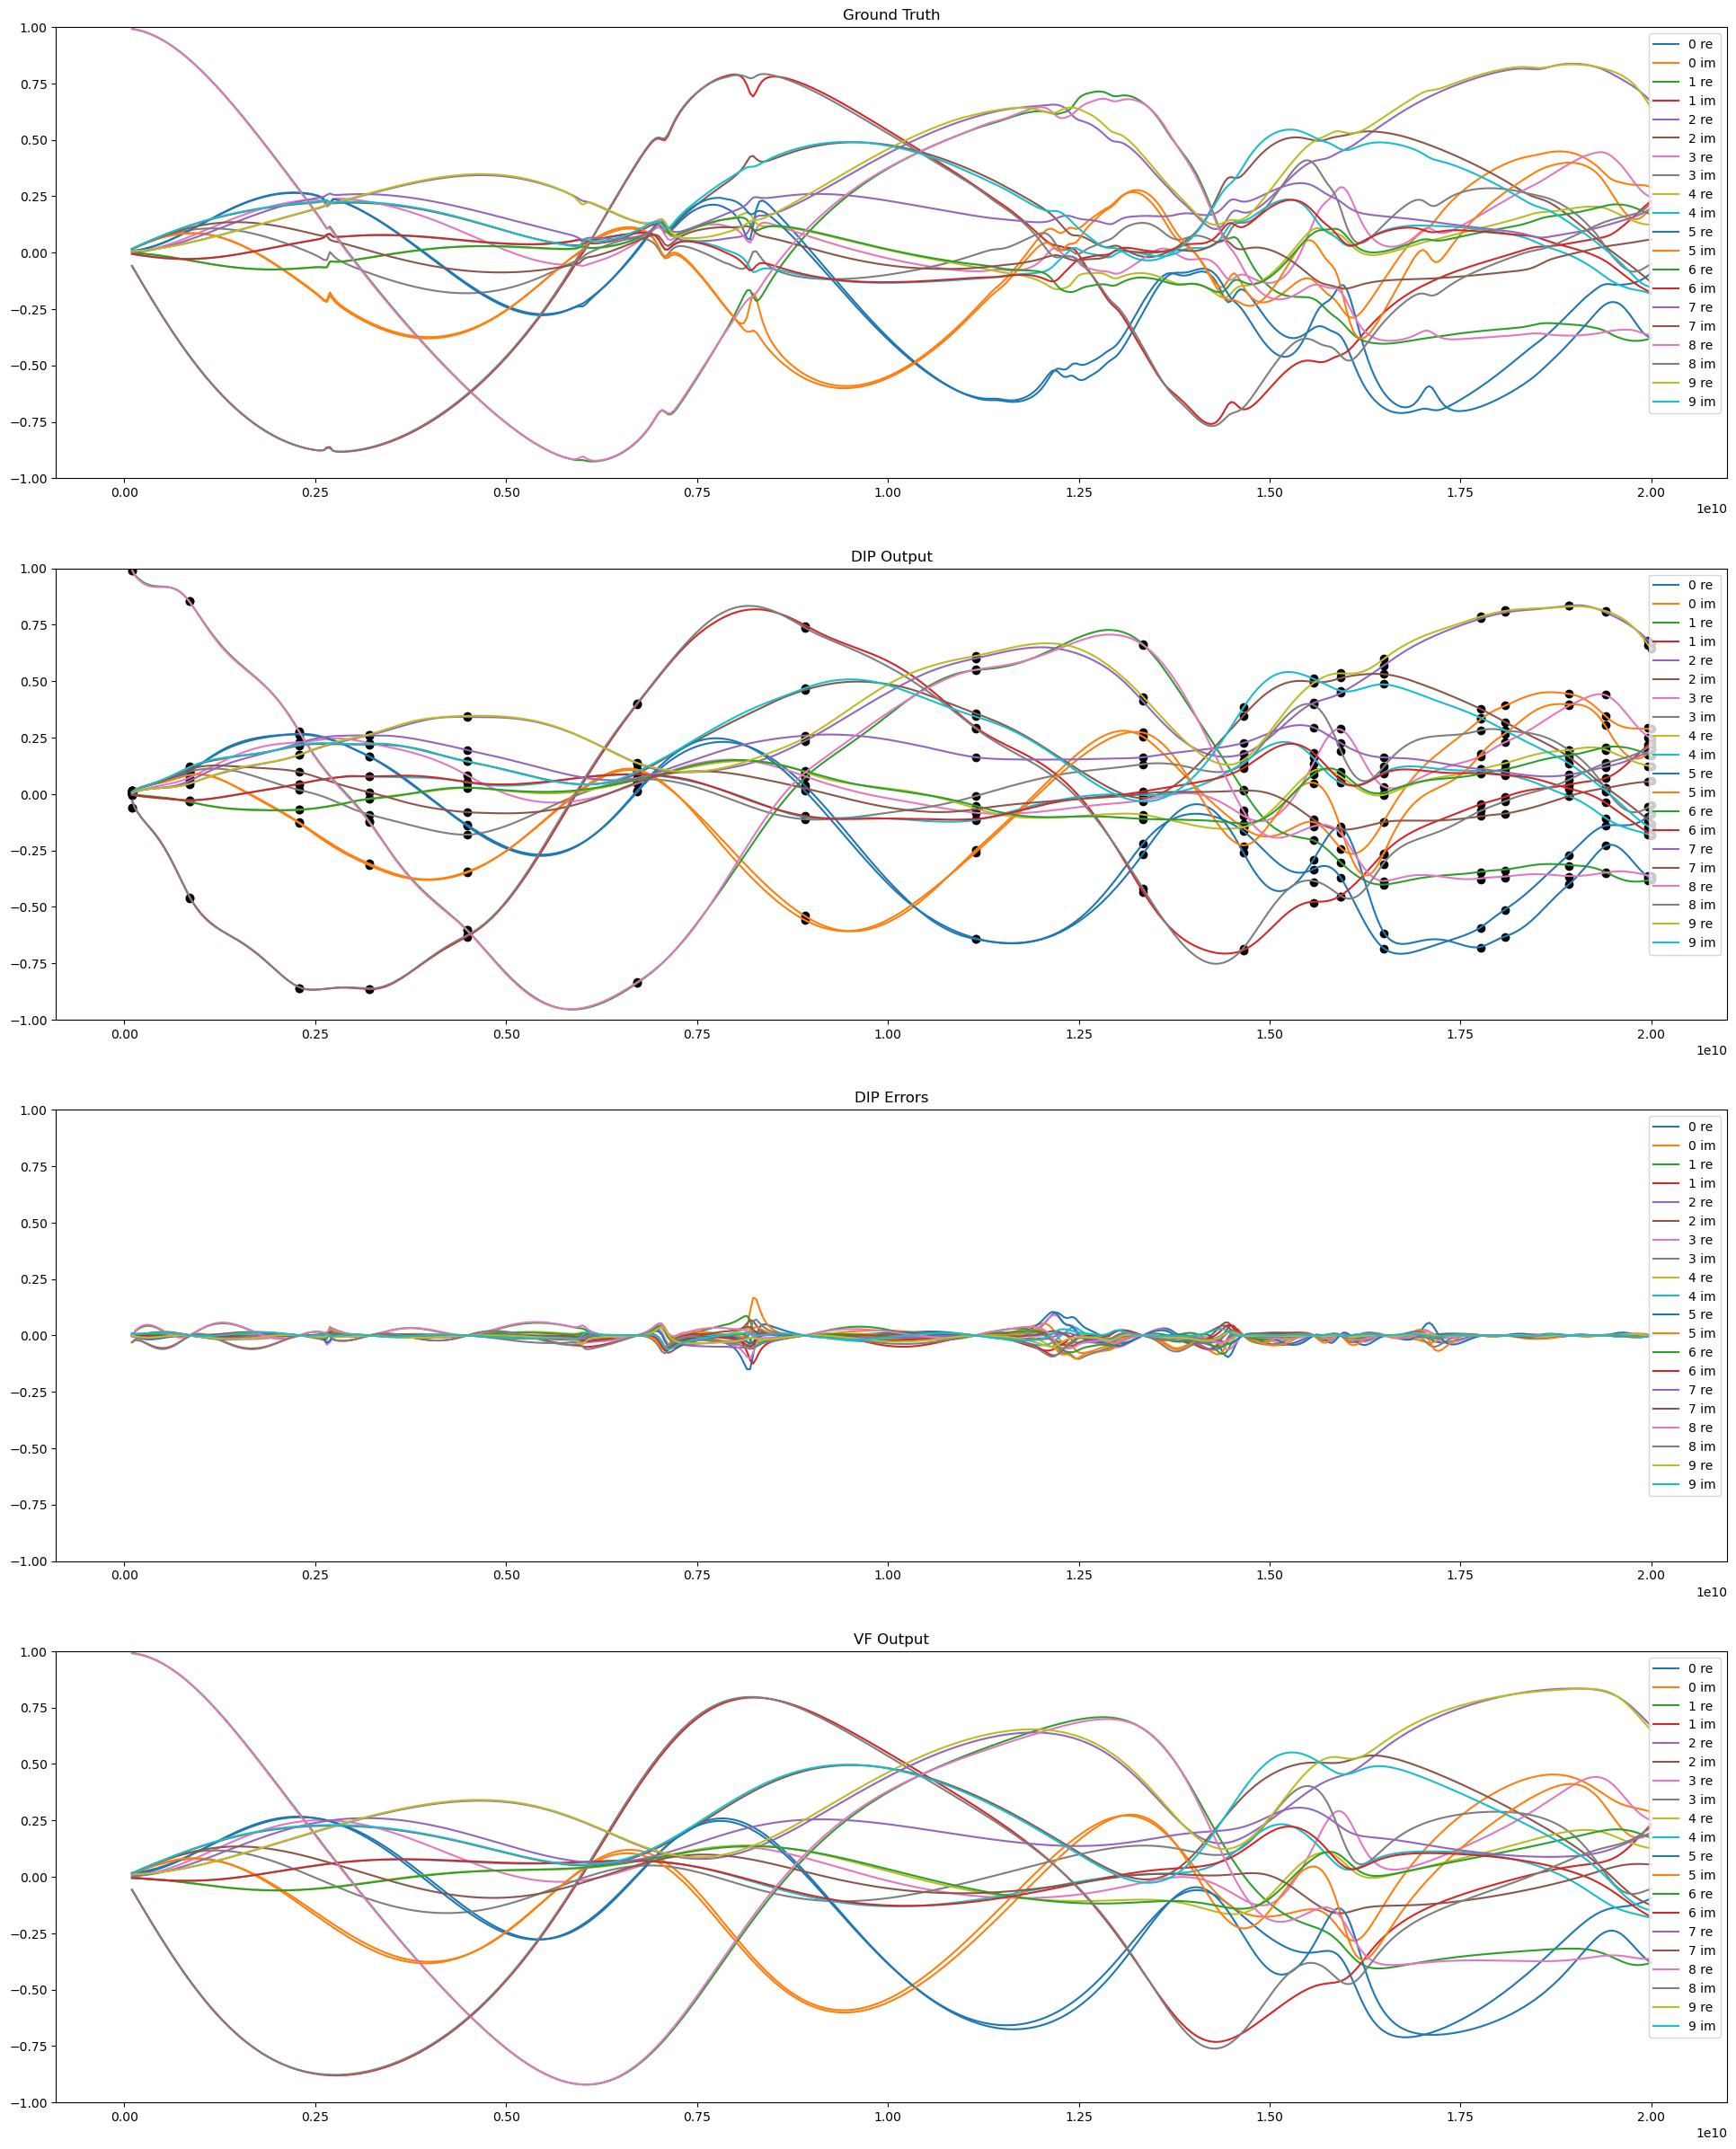

In [55]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [51]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[5.1556e-04, 5.0846e-04, 4.8031e-04, 4.7490e-04, 4.9358e-04, 4.9799e-04,
         4.8598e-04, 4.8718e-04, 5.0173e-04, 5.1494e-04, 5.2699e-04, 5.4122e-04,
         5.5803e-04, 5.7897e-04, 6.0390e-04, 6.2357e-04, 6.3799e-04, 6.4541e-04,
         6.4584e-04, 6.4212e-04, 6.3405e-04, 6.3666e-04, 6.5066e-04, 6.5394e-04,
         6.4665e-04, 6.5073e-04, 6.3674e-04, 6.7120e-04, 7.0268e-04, 5.3019e-04,
         5.6826e-04, 5.9415e-04, 5.9747e-04, 5.8976e-04, 5.7613e-04, 5.7500e-04,
         5.8032e-04, 5.9220e-04, 6.1082e-04, 6.2782e-04, 6.4314e-04, 6.6280e-04,
         6.2539e-04, 6.1833e-04, 6.2559e-04, 6.0255e-04, 5.7601e-04, 5.6162e-04,
         5.4214e-04, 5.0614e-04, 4.8892e-04, 4.6166e-04, 4.1658e-04, 3.6905e-04,
         3.2711e-04, 2.5097e-04, 2.5220e-04, 2.6739e-04, 2.9555e-04, 3.4033e-04,
         3.8835e-04, 4.6783e-04, 5.3905e-04, 5.5141e-04, 5.0267e-04, 4.4307e-04,
         3.3456e-04, 2.5818e-04, 1.8456e-04, 1.6882e-04, 1.5253e-04, 1.5581e-04,
         1.7700e-04, 2.4771e

In [52]:
print(dip_errors[-1])

tensor([[ 4.4902e-04, -6.3163e-03, -9.9271e-03, -1.2652e-02, -1.4499e-02,
         -1.5462e-02, -1.5552e-02, -1.4911e-02, -1.3556e-02, -1.1772e-02,
         -9.5824e-03, -7.2974e-03, -4.9403e-03, -2.8125e-03, -9.3764e-04,
          4.4278e-04,  1.3043e-03,  1.5013e-03,  1.0135e-03, -8.2269e-05,
         -1.8082e-03, -3.6667e-03, -5.6770e-03, -7.5782e-03, -9.3923e-03,
         -1.0990e-02, -1.2335e-02, -1.3501e-02, -1.4282e-02, -1.4766e-02,
         -1.5003e-02, -1.4989e-02, -1.4595e-02, -1.3968e-02, -1.3167e-02,
         -1.2202e-02, -1.1088e-02, -9.8731e-03, -8.5709e-03, -7.2419e-03,
         -5.9002e-03, -4.6292e-03, -3.2987e-03, -2.0293e-03, -9.3858e-04,
         -1.0049e-04,  7.2250e-04,  1.3691e-03,  1.8614e-03,  2.1448e-03,
          2.2244e-03,  2.1573e-03,  1.9166e-03,  1.5176e-03,  9.4801e-04,
          2.2805e-04, -4.4796e-04, -1.1323e-03, -1.7943e-03, -2.5894e-03,
         -3.6463e-03, -5.3384e-03, -8.4540e-03, -1.6149e-02, -3.9601e-02,
         -2.5537e-02, -7.7741e-04,  3.

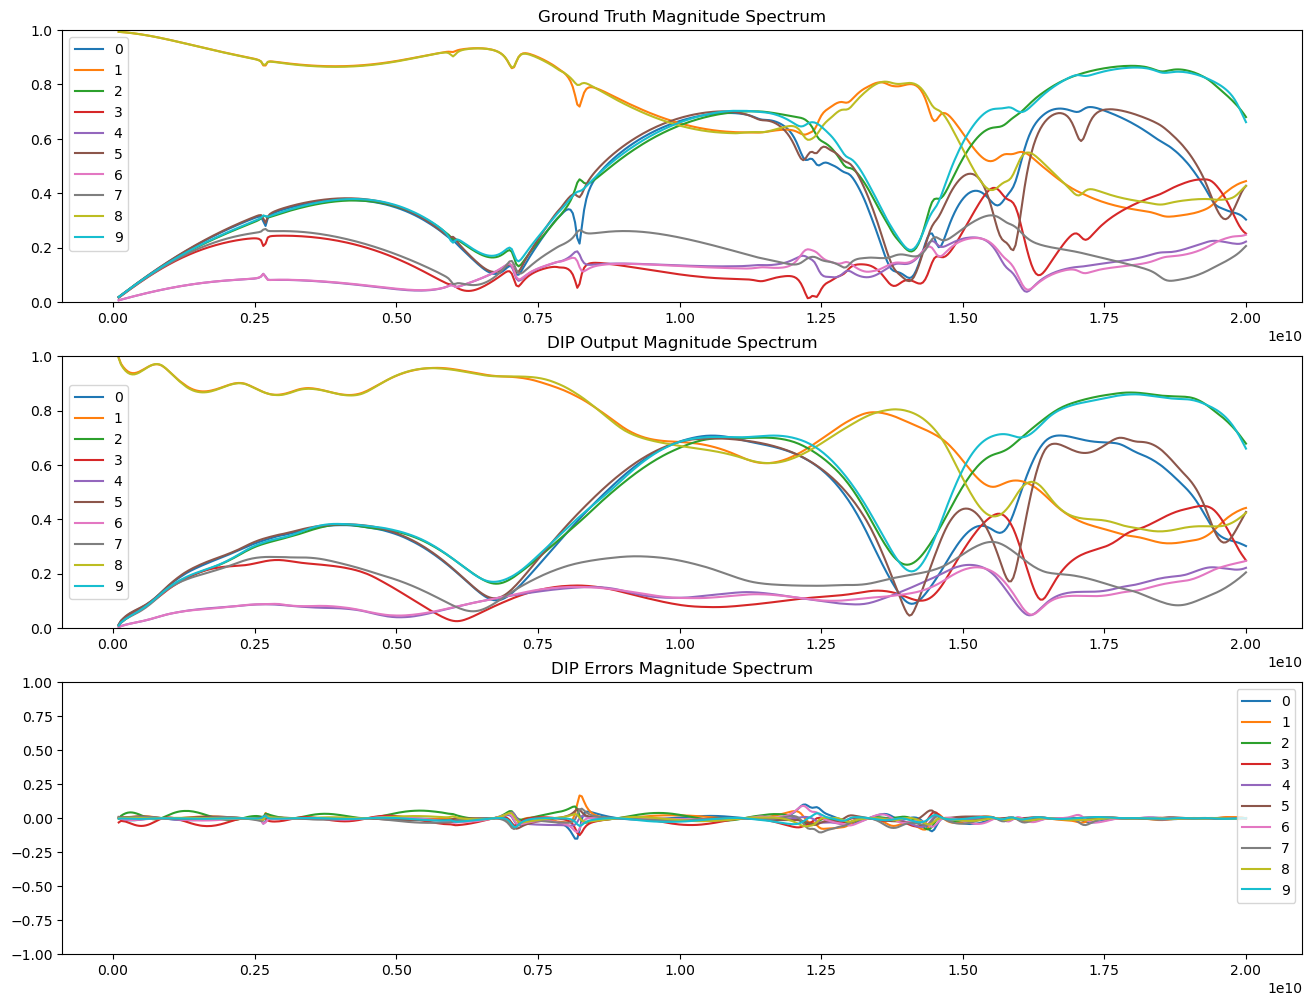

In [53]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [54]:
print(kept_inds)

[  0  19  55  78 110 166 221 277 332 365 388 397 411 443 451 472 484 498
 499]
